## Pseudo-elastic Equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
%matplotlib inline

# Make background for figures white
plt.rcParams['figure.facecolor'] = 'white'

In [44]:
def plot_fn_snapshot(fn, fig=None, axs=None, **kwargs):
    if fig is None and axs is None:
        fig, axs = plt.subplots(1, 1)
        im = axs.imshow(fn, **kwargs)
        return fig, axs, im
    
    im = axs.imshow(fn, **kwargs)
    return fig, axs, im

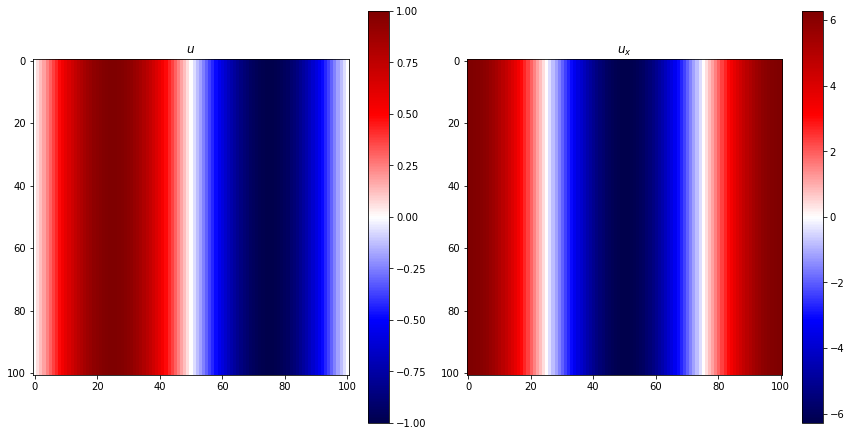

In [86]:
size = (101, 101)
u_initial = np.zeros(size)
u_dx = np.zeros(size)
# Set initial condition velocity
for i in range(size[0]):
    y = i / (size[0] - 1)
    for j in range(size[1]):
        x = j / (size[1] - 1)
        u_initial[i, j] = np.sin(2 * np.pi * x)
        u_dx[i, j] = 2 * np.pi * np.cos(2 * np.pi * x)

# fig, axs = plt.subplots(1, 1)
# fig, axs, im = plot_fn_snapshot(u_initial)
# fig.colorbar(im)
# plt.suptitle(r"$u$")
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
_, _, im0 = plot_fn_snapshot(u_initial, axs=axs[0], cmap='seismic')
_, _, im1 = plot_fn_snapshot(u_dx, axs=axs[1], cmap='seismic')
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
axs[0].set_title(r"$u$")
axs[1].set_title(r"$u_x$")
fig.tight_layout(pad=0.5)

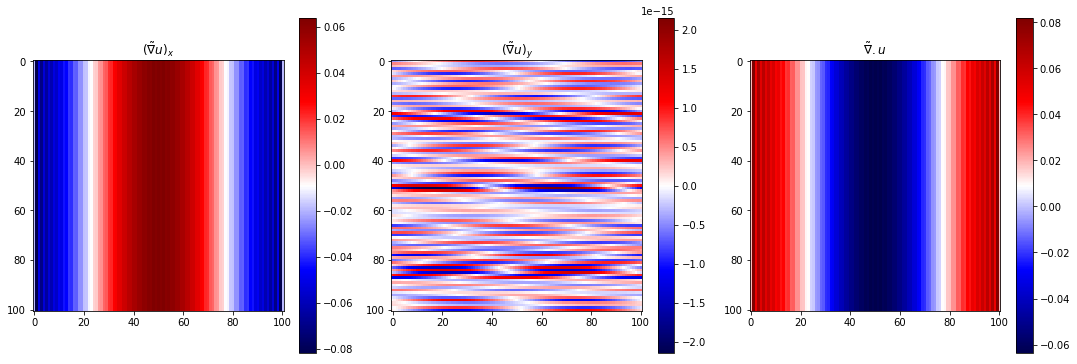

In [91]:
def normalized_gradient(f, dim=2, eps=1e-6):
    size = f.data.shape
    f_x, f_y = fft.fftfreq(size[1]), fft.fftfreq(size[0])
    f_fft = fft.fftn(f)
#     norm_grad = np.zeros((f.shape[0], f.shape[1], dim), dtype=complex)
    ddx = np.zeros(f.shape, dtype=complex)
    ddy = np.zeros(f.shape, dtype=complex)
    for i in range(f_fft.shape[0]):
        for j in range(f_fft.shape[1]):
            k_x, k_y = f_x[j], f_y[i]
            ddx[i, j] = -(2j * np.pi * k_x) * f_fft[i, j] # / (k_x**2 + k_y**2 + eps)
            ddy[i, j] = -(2j * np.pi * k_y) * f_fft[i, j] # / (k_x**2 + k_y**2 + eps)
    ddx = fft.ifftn(ddx)
    ddy = fft.ifftn(ddy)
    return ddx, ddy

# fig, axs = plt.subplots(1, 2)
ddx, ddy = normalized_gradient(u_initial)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

fig, axs[0], im0 = plot_fn_snapshot(np.real(ddx), fig=fig, axs=axs[0], cmap='seismic')
cbar0 = fig.colorbar(im0, ax=axs[0])
axs[0].set_title(r"$(\tilde{\nabla}u)_x$")

fig, axs[1], im1 = plot_fn_snapshot(np.real(ddy), fig=fig, axs=axs[1], cmap='seismic')
cbar1 = fig.colorbar(im1, ax=axs[1])
axs[1].set_title(r"$(\tilde{\nabla}u)_y$")

fig, axs[2], im2 = plot_fn_snapshot(np.real(-ddy -ddx), fig=fig, axs=axs[2], cmap='seismic')
cbar2 = fig.colorbar(im2, ax=axs[2])
axs[2].set_title(r"$\tilde{\nabla} . u$")

fig.tight_layout(pad=0.5)

In [81]:
print(np.abs(ddx))

[[1.38023873 0.64008703 0.37056472 ... 0.37056472 0.64008703 1.38023873]
 [1.38023873 0.64008703 0.37056472 ... 0.37056472 0.64008703 1.38023873]
 [1.38023873 0.64008703 0.37056472 ... 0.37056472 0.64008703 1.38023873]
 ...
 [1.38023873 0.64008703 0.37056472 ... 0.37056472 0.64008703 1.38023873]
 [1.38023873 0.64008703 0.37056472 ... 0.37056472 0.64008703 1.38023873]
 [1.38023873 0.64008703 0.37056472 ... 0.37056472 0.64008703 1.38023873]]
